# Logistic Regression Experiments

Imports and Helper Functions
---

In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

## Model Creation

In [21]:
class LR(nn.Module):
    def __init__(self, D):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(D,1)
        self.fc1.weight.data.zero_()
        self.fc1.bias.data.zero_()

    def predict(self,X):
        z = self.fc1(X)
        return 0.0+(torch.sigmoid(z)>=0.5)

    def forward(self, X):
        z = self.fc1(X)
        return torch.sigmoid(z)

    def fit(self, X, y, lr=1, maxiter=100):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        loss_values=[]

        for epoch in range(maxiter):
            optimizer.zero_grad()
            p = self.forward(X)
            loss = -1*torch.mean(y*torch.log(p) + (1-y)*torch.log(1-p))

            if(torch.isnan(loss)):
                print("Warning: loss is nan. Aborting learning. Try decreasing the step size.")
                break

            loss.backward()
            optimizer.step()

            loss_values.append(loss.detach().item())

        return(loss_values)


## Load data

In [22]:
data = torch.load("data.pt",weights_only=False)
X = data["X"]
y = data["y"]

## Question 3a

Training with learning rate: 1e-05
Training with learning rate: 0.0001
Training with learning rate: 0.001
Training with learning rate: 0.01


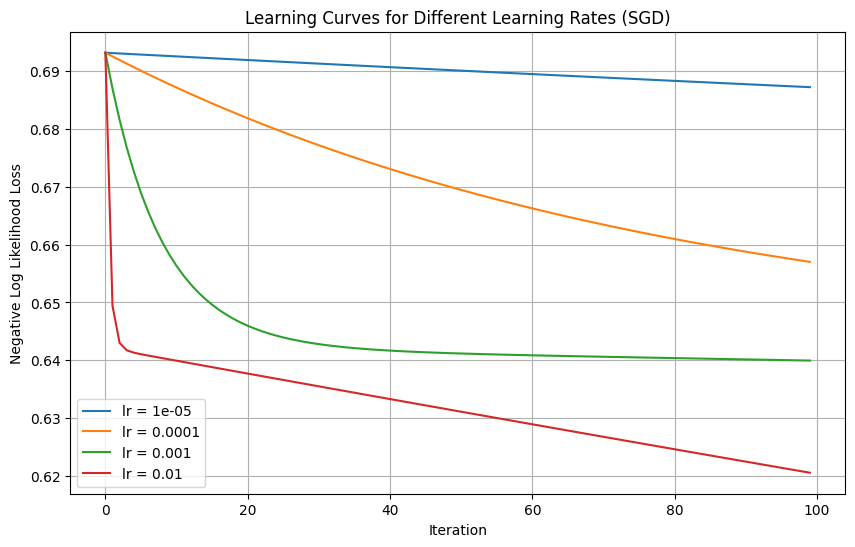

Training Error Rates:
         Training Error Rate
0.00001               0.5000
0.00010               0.5000
0.00100               0.5000
0.01000               0.5000


In [23]:
# Learning rates to test
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
loss_curves = {}
error_rates = {}
max_iter = 100

# Train the model for each learning rate
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model_3a = LR(2)
    losses = model_3a.fit(X, y, lr=lr, maxiter=max_iter)
    loss_curves[lr] = losses

    # Calculate training error
    with torch.no_grad():
        y_pred = model_3a.predict(X)
        error = torch.mean((y_pred.squeeze() != y.squeeze()).float()).item()
        error_rates[lr] = error

# Plot the learning curves
plt.figure(figsize=(10, 6))
for lr, losses in loss_curves.items():
    plt.plot(range(len(losses)), losses, label=f'lr = {lr}')
plt.title('Learning Curves for Different Learning Rates (SGD)')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood Loss')
plt.legend()
plt.grid(True)
plt.show()

# Display the training error rates in a table
error_df = pd.DataFrame.from_dict(error_rates, orient='index', columns=['Training Error Rate'])
print("Training Error Rates:")
print(error_df.to_string(float_format="%.4f"))

## Question 3b

Training with SGD optimizer (lr=0.1)...
Training with MOMENTUM optimizer (lr=0.1)...
Training with RMSPROP optimizer (lr=0.1)...
Training with ADAM optimizer (lr=0.1)...


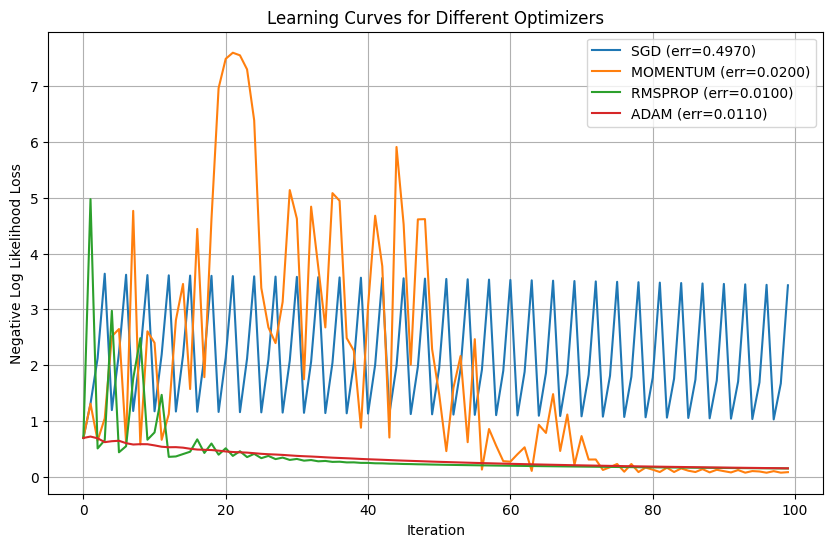

Final Training Error with SGD: 0.4970
Final Training Error with MOMENTUM: 0.0200
Final Training Error with RMSPROP: 0.0100
Final Training Error with ADAM: 0.0110


In [24]:
class LR_Optimized(LR):
    def fit(self, X, y, optimizer_name='adam', lr=0.1, maxiter=100):
        if optimizer_name.lower() == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=lr)
        elif optimizer_name.lower() == 'momentum':
            optimizer = optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        elif optimizer_name.lower() == 'rmsprop':
            optimizer = optim.RMSprop(self.parameters(), lr=lr)
        elif optimizer_name.lower() == 'adam':
            optimizer = optim.Adam(self.parameters(), lr=lr)
        else:
            raise ValueError("Unsupported optimizer specified.")

        loss_values = []
        for epoch in range(maxiter):
            optimizer.zero_grad()
            p = self.forward(X)
            epsilon = 1e-7
            loss = -1 * torch.mean(y * torch.log(p + epsilon) + (1 - y) * torch.log(1 - p + epsilon))
            if torch.isnan(loss):
                print(f"Warning: loss is nan at epoch {epoch}.")
                break
            loss.backward()
            optimizer.step()
            loss_values.append(loss.detach().item())
        return loss_values

# Train and compare all optimizers
optimizers = ['sgd', 'momentum', 'rmsprop', 'adam']
results = {}

for opt in optimizers:
    print(f"Training with {opt.upper()} optimizer (lr=0.1)...")
    model = LR_Optimized(2)
    losses = model.fit(X, y, optimizer_name=opt, lr=0.1, maxiter=100)
    with torch.no_grad():
        y_pred = model.predict(X)
        error = torch.mean((y_pred.squeeze() != y.squeeze()).float()).item()
    results[opt] = {'losses': losses, 'final_error': error}

# Plot learning curves
plt.figure(figsize=(10, 6))
for opt in optimizers:
    plt.plot(results[opt]['losses'], label=f"{opt.upper()} (err={results[opt]['final_error']:.4f})")
plt.title('Learning Curves for Different Optimizers')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood Loss')
plt.legend()
plt.grid(True)
plt.show()

# Report errors
for opt in optimizers:
    print(f"Final Training Error with {opt.upper()}: {results[opt]['final_error']:.4f}")


## Question 3c

Data Statistics (Original):
  Means: [1.5027445e+01 1.4981112e-02]
  Standard Deviations: [5.4284053  0.00543306]
Observation: Feature 1 has a much larger scale (std ~57) than Feature 0 (std ~1.4).



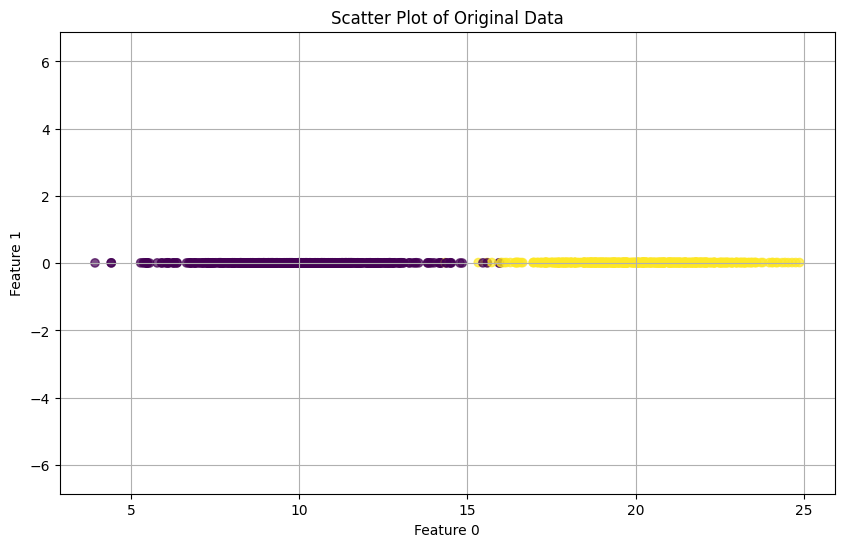

Data Statistics (Standardized):
  New Means: [1.3971329e-07 1.9073486e-08]
  New Standard Deviations: [1.         0.99999994]

Re-training with SGD on standardized data (lr=1.0)...


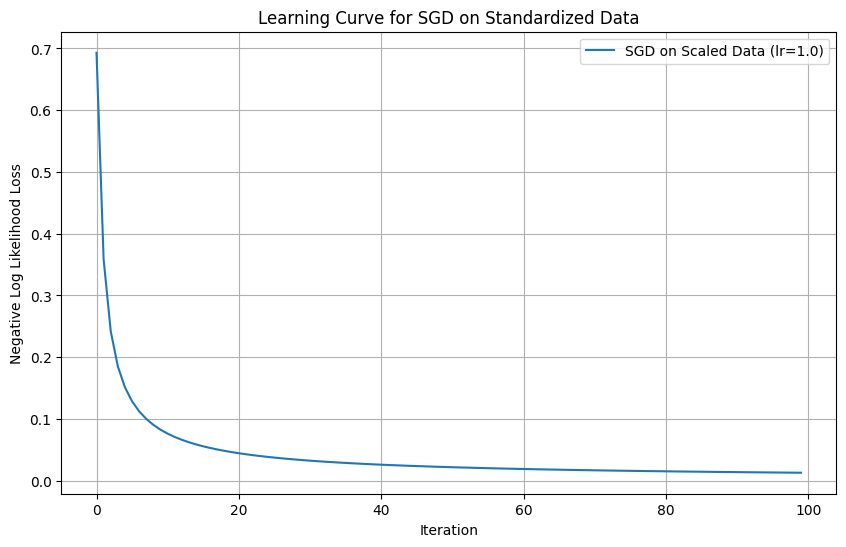

Explanation: The data had features with very different scales, which makes gradient descent converge slowly. By standardizing the features (mean=0, std=1), the loss function becomes more spherical, allowing even basic SGD to find the minimum efficiently.
Final Training Error with SGD on Standardized Data: 0.0000


In [25]:
# 1. Investigate the data statistics to verify the hypothesis
feature_means = X.mean(dim=0)
feature_stds = X.std(dim=0)
print("Data Statistics (Original):")
print(f"  Means: {feature_means.numpy()}")
print(f"  Standard Deviations: {feature_stds.numpy()}")
print("Observation: Feature 1 has a much larger scale (std ~57) than Feature 0 (std ~1.4).\n")


# 2. Visualize the original data with a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y.numpy(), cmap='viridis', alpha=0.7)
plt.title('Scatter Plot of Original Data')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.grid(True)
plt.axis('equal') # Use equal scaling to visualize the disparity
plt.show()


# 3. Standardize the data to have zero mean and unit variance
X_scaled = (X - feature_means) / feature_stds

# Verify the new stats
print("Data Statistics (Standardized):")
print(f"  New Means: {X_scaled.mean(dim=0).numpy()}")
print(f"  New Standard Deviations: {X_scaled.std(dim=0).numpy()}\n")


# 4. Re-run the experiment with standard SGD on the scaled data
print("Re-training with SGD on standardized data (lr=1.0)...")
# We can now use a much larger learning rate
model_3c = LR(2)
scaled_losses = model_3c.fit(X_scaled, y, lr=1.0, maxiter=100)

# Calculate final training error
with torch.no_grad():
    y_pred_scaled = model_3c.predict(X_scaled)
    final_error_scaled = torch.mean((y_pred_scaled.squeeze() != y.squeeze()).float()).item()

# Plot the learning curve for SGD on scaled data
plt.figure(figsize=(10, 6))
plt.plot(scaled_losses, label='SGD on Scaled Data (lr=1.0)')
plt.title('Learning Curve for SGD on Standardized Data')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Explanation: The data had features with very different scales, which makes gradient descent converge slowly. By standardizing the features (mean=0, std=1), the loss function becomes more spherical, allowing even basic SGD to find the minimum efficiently.")
print(f"Final Training Error with SGD on Standardized Data: {final_error_scaled:.4f}")